DataBase Description:
The Complete Journey
Source: Dunnhumby
Description:
completejourney provides access to data sets characterizing household level transactions over one year from a group of 2,469 households who are frequent shoppers at a grocery store. It contains all of each household’s purchases, not just those from a limited number of categories. For certain households, demographic information as well as direct marketing contact history are captured.
There are eight built-in data sets available in this package. The data sets include:

- campaigns: campaigns received by each household
- campaign_descriptions: campaign metadata (length of time active)
- coupons: coupon metadata (UPC code, campaign, etc.)
- coupon_redemptions: coupon redemptions (household, day, UPC code, campaign)
- demographics: household demographic data (age, income, family size, etc.)
- products: product metadata (brand, description, etc.)
- promotions_sample: a sampling of the product placement in mailers and in stores corresponding to advertising campaigns
- transactions_sample: a sampling of the products purchased by households


## Setup & Imports


In [1]:
# Import necessary libraries
import plotly
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
# Set Parameters
warnings.filterwarnings("ignore")
dataset_folder = "../Data/"
export_folder = "../Export/"
np.random.seed(42)  # Setup numpy seed for reproducibility

In [3]:
# Load the dataset's csv files
with tqdm(total=4) as pbar:
    df_product = pd.read_csv(dataset_folder + "product.csv")
    pbar.update(1)
    df_demographic = pd.read_csv(dataset_folder + "hh_demographic.csv")
    pbar.update(1)
    df_trnsct = pd.read_csv(dataset_folder + "transaction_data.csv")
    pbar.update(1)
    df_campaign = pd.read_csv(dataset_folder + "campaign_desc.csv")
    pbar.update(1)

# Print loaded datasets file names
print(
    f"Loaded 4 datasets: product.csv, hh_demographic.csv, transaction_data.csv, campaign_desc.csv"
)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

Loaded 4 datasets: product.csv, hh_demographic.csv, transaction_data.csv, campaign_desc.csv


---

# Traitement des Valeurs Manquantes


In this part we will process the missing values

## 1. Demographic Dataframe

#### a. General Analysis

In [266]:
df_demographic.head(5)

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [267]:
df_demographic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   AGE_DESC             801 non-null    object
 1   MARITAL_STATUS_CODE  801 non-null    object
 2   INCOME_DESC          801 non-null    object
 3   HOMEOWNER_DESC       801 non-null    object
 4   HH_COMP_DESC         801 non-null    object
 5   HOUSEHOLD_SIZE_DESC  801 non-null    object
 6   KID_CATEGORY_DESC    801 non-null    object
 7   household_key        801 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 50.2+ KB


We can see that the columns ['HOMEOWNER_DESC', 'HH_COMP_DESC', 'KID_CATEGORY_DESC','MARITAL_STATUS'] all have missing values as Unknwown or None/Unknown

##### b. KID_CATEGORY_DESC

In [268]:
df_demographic["KID_CATEGORY_DESC"].value_counts()

KID_CATEGORY_DESC
None/Unknown    558
1               114
3+               69
2                60
Name: count, dtype: int64

In [269]:
# Get the 'HH_COMP_DESC' values where 'KID_CATEGORY_DESC' is 'None/Unknown' in the df_demographic DataFrame
# Then, count the unique values of 'HH_COMP_DESC'
df_demographic[df_demographic["KID_CATEGORY_DESC"] == "None/Unknown"][
    "HH_COMP_DESC"
].value_counts()

HH_COMP_DESC
2 Adults No Kids    255
Single Female       144
Single Male          95
Unknown              64
Name: count, dtype: int64

We can see that the majority of KIDS marked as None/Unknown are from adults with no kids ['2 Adults No Kids', 'Single Female', 'Single Male']. <br/>
We can set those values to 0.


In [270]:
# Update the 'KID_CATEGORY_DESC' column in the df_demographic DataFrame
df_demographic["KID_CATEGORY_DESC"] = np.where(
    # Condition: If 'KID_CATEGORY_DESC' is 'None/Unknown' AND 'HH_COMP_DESC' is not 'Unknown'
    (df_demographic["KID_CATEGORY_DESC"] == "None/Unknown")
    & (~(df_demographic["HH_COMP_DESC"] == "Unknown")),
    0,  # If condition is True, set value to 0
    df_demographic[
        "KID_CATEGORY_DESC"
    ],  # If condition is False, keep the original value
)
df_demographic["KID_CATEGORY_DESC"].value_counts()

KID_CATEGORY_DESC
0               494
1               114
3+               69
None/Unknown     64
2                60
Name: count, dtype: int64

In [271]:
# Filter the df_demographic DataFrame to only include rows where 'KID_CATEGORY_DESC' is 'None/Unknown'
# Then, select the 'HOUSEHOLD_SIZE_DESC', 'HH_COMP_DESC', and 'MARITAL_STATUS_CODE' columns from this filtered DataFrame
# Finally, count the unique combinations of these three columns
df_demographic[df_demographic["KID_CATEGORY_DESC"] == "None/Unknown"][
    ["HOUSEHOLD_SIZE_DESC", "HH_COMP_DESC", "MARITAL_STATUS_CODE"]
].value_counts()

HOUSEHOLD_SIZE_DESC  HH_COMP_DESC  MARITAL_STATUS_CODE
1                    Unknown       U                      59
2                    Unknown       A                       3
1                    Unknown       B                       2
Name: count, dtype: int64

We can see that the remaining Unknown kids can be deduced from the household size as Household Size of 1 has no kids. Both household types are of an unknown composition. The households having 2 persons are married. We can assume that therefore, they have no kids.

In [272]:
df_demographic["KID_CATEGORY_DESC"].replace(
    "None/Unknown", 0, inplace=True
)  # Replace 'None/Unknown' with 0
df_demographic["KID_CATEGORY_DESC"].value_counts()

KID_CATEGORY_DESC
0     558
1     114
3+     69
2      60
Name: count, dtype: int64

In [273]:
# Replace the 3+ values in the 'KID_CATEGORY_DESC' column with 3 to convert the column to integers.
df_demographic["KID_CATEGORY_DESC"] = (
    df_demographic["KID_CATEGORY_DESC"].replace("3+", 3).astype(int)
)
df_demographic["KID_CATEGORY_DESC"].value_counts()

KID_CATEGORY_DESC
0    558
1    114
3     69
2     60
Name: count, dtype: int64

#### c. HH_COMP_DESC

In [274]:
# know the different category of data in column HH_COMP_DESC
df_demographic["HH_COMP_DESC"].value_counts()

HH_COMP_DESC
2 Adults No Kids    255
2 Adults Kids       187
Single Female       144
Single Male          95
Unknown              73
1 Adult Kids         47
Name: count, dtype: int64

In [275]:
# Filter the df_demographic DataFrame to only include rows where 'HH_COMP_DESC' is 'Unknown'
# Then, select the 'HOUSEHOLD_SIZE_DESC' and 'KID_CATEGORY_DESC' columns from this filtered DataFrame
# Finally, count the unique combinations of these two columns.
df_demographic[df_demographic["HH_COMP_DESC"] == "Unknown"][
    ["HOUSEHOLD_SIZE_DESC", "KID_CATEGORY_DESC"]
].value_counts()

HOUSEHOLD_SIZE_DESC  KID_CATEGORY_DESC
1                    0                    61
3                    1                     5
2                    0                     3
5+                   3                     3
2                    1                     1
Name: count, dtype: int64

We can fill the Houses with 1 person and no kids as a new value: '1 Adult No Kids'

In [276]:
# Update the 'HH_COMP_DESC' column in the df_demographic DataFrame
df_demographic["HH_COMP_DESC"] = np.where(
    # Condition: If 'HH_COMP_DESC' is 'Unknown' AND 'HOUSEHOLD_SIZE_DESC' is '1'
    (df_demographic["HH_COMP_DESC"] == "Unknown")
    & (df_demographic["HOUSEHOLD_SIZE_DESC"] == "1"),
    "1 Adult No Kids",  # If condition is True, set value to '1 Adult No Kids'
    df_demographic["HH_COMP_DESC"],  # If condition is False, keep the original value
)
df_demographic["HH_COMP_DESC"].value_counts()

HH_COMP_DESC
2 Adults No Kids    255
2 Adults Kids       187
Single Female       144
Single Male          95
1 Adult No Kids      61
1 Adult Kids         47
Unknown              12
Name: count, dtype: int64

In [277]:
# List of data with "Unknown" answer in column HH_COMP_DESC
df_demographic[df_demographic["HH_COMP_DESC"] == "Unknown"]

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
87,35-44,A,Under 15K,Renter,Unknown,3,1,249
140,25-34,A,25-34K,Unknown,Unknown,2,0,404
194,45-54,A,125-149K,Homeowner,Unknown,3,1,582
218,55-64,A,50-74K,Homeowner,Unknown,2,0,660
341,35-44,A,35-49K,Unknown,Unknown,5+,3,1012
375,45-54,U,50-74K,Unknown,Unknown,2,1,1135
382,45-54,A,35-49K,Homeowner,Unknown,2,0,1154
505,45-54,A,75-99K,Homeowner,Unknown,3,1,1563
579,45-54,U,125-149K,Homeowner,Unknown,5+,3,1834
584,45-54,A,75-99K,Homeowner,Unknown,3,1,1848


We can see that we can deduce the household composition from the diffrence between the Household size and the number of kids.

In [278]:
# First we need to convert the column to int and replace the '5+' values with 5 to do so.
df_demographic["HOUSEHOLD_SIZE_DESC"] = (
    df_demographic["HOUSEHOLD_SIZE_DESC"].replace("5+", 5).astype(int)
)
df_demographic["HH_COMP_DESC"].value_counts()

HH_COMP_DESC
2 Adults No Kids    255
2 Adults Kids       187
Single Female       144
Single Male          95
1 Adult No Kids      61
1 Adult Kids         47
Unknown              12
Name: count, dtype: int64

In [279]:
# Define the condition lists
unknown_cond = df_demographic["HH_COMP_DESC"] == "Unknown"
conditions = [
    (
        unknown_cond
        & (
            df_demographic["HOUSEHOLD_SIZE_DESC"] - df_demographic["KID_CATEGORY_DESC"]
            == 2
        )
        & (df_demographic["KID_CATEGORY_DESC"] == 0)
    ),
    (
        unknown_cond
        & (
            df_demographic["HOUSEHOLD_SIZE_DESC"] - df_demographic["KID_CATEGORY_DESC"]
            == 2
        )
        & (df_demographic["KID_CATEGORY_DESC"] != 0)
    ),
    (
        unknown_cond
        & (
            df_demographic["HOUSEHOLD_SIZE_DESC"] - df_demographic["KID_CATEGORY_DESC"]
            == 1
        )
        & (df_demographic["KID_CATEGORY_DESC"] == 0)
    ),
    (
        unknown_cond
        & (
            df_demographic["HOUSEHOLD_SIZE_DESC"] - df_demographic["KID_CATEGORY_DESC"]
            == 1
        )
        & (df_demographic["KID_CATEGORY_DESC"] != 0)
    ),
]

# Define the choice list
choices = ["2 Adults No Kids", "2 Adults Kids", "1 Adult No Kids", "1 Adult Kids"]

# Create a new column with the new values
df_demographic["HH_COMP_DESC"] = np.select(
    conditions, choices, default=df_demographic["HH_COMP_DESC"]
)

df_demographic["HH_COMP_DESC"].value_counts()

HH_COMP_DESC
2 Adults No Kids    258
2 Adults Kids       195
Single Female       144
Single Male          95
1 Adult No Kids      61
1 Adult Kids         48
Name: count, dtype: int64

#### d. HOMEOWNER_DESC

In [280]:
# Know the different distribution of "HOMEOWNER_DESC"
df_demographic["HOMEOWNER_DESC"].value_counts()

HOMEOWNER_DESC
Homeowner          504
Unknown            233
Renter              42
Probable Renter     11
Probable Owner      11
Name: count, dtype: int64

In [281]:
# Replace 'Unknown' values in the 'HOMEOWNER_DESC' column of the df_demographic DataFrame with NA (missing) values
df_demographic["HOMEOWNER_DESC"].replace("Unknown", pd.NA, inplace=True)

We will fill the Homeowner description column with the same distribution as the non missing values

In [282]:
# Create a dictionnary with the ratio of each non NA value in the column
homeowner_probability = (
    df_demographic["HOMEOWNER_DESC"].value_counts(normalize=True).to_dict()
)
homeowner_probability

{'Homeowner': 0.8873239436619719,
 'Renter': 0.07394366197183098,
 'Probable Renter': 0.01936619718309859,
 'Probable Owner': 0.01936619718309859}

In [283]:
# Fill the NA values with np.random while passing the existing values ratio as probability to the random function
df_demographic["HOMEOWNER_DESC"] = df_demographic["HOMEOWNER_DESC"].fillna(
    np.random.choice(
        list(homeowner_probability.keys()), p=list(homeowner_probability.values())
    )
)
df_demographic["HOMEOWNER_DESC"].value_counts(normalize=True)

HOMEOWNER_DESC
Homeowner          0.920100
Renter             0.052434
Probable Renter    0.013733
Probable Owner     0.013733
Name: proportion, dtype: float64

#### e. MARITAL_STATUS_CODE

In [284]:
# Know the different distribution of "MARITAL_STATUS_CODE"
df_demographic["MARITAL_STATUS_CODE"].value_counts()

MARITAL_STATUS_CODE
U    344
A    340
B    117
Name: count, dtype: int64

In [285]:
# We can probably infer the marital status from the 'HH_COMP_DESC' column
df_demographic[["HH_COMP_DESC", "MARITAL_STATUS_CODE"]].value_counts().sort_index()

HH_COMP_DESC      MARITAL_STATUS_CODE
1 Adult Kids      A                       16
                  B                       14
                  U                       18
1 Adult No Kids   B                        2
                  U                       59
2 Adults Kids     A                      141
                  B                        9
                  U                       45
2 Adults No Kids  A                      138
                  B                       28
                  U                       92
Single Female     A                       33
                  B                       39
                  U                       72
Single Male       A                       12
                  B                       25
                  U                       58
Name: count, dtype: int64

In [286]:
# Replace the 'U' values in the 'MARITAL_STATUS_CODE' column of the df_demographic DataFrame with NA (missing) values
# And then see the distribution between 'A': Married & 'B': Single for each Household composition
marital_proba = (
    df_demographic[["HH_COMP_DESC", "MARITAL_STATUS_CODE"]]
    .replace("U", np.NaN)
    .value_counts()
    .sort_index()
)
marital_proba

HH_COMP_DESC      MARITAL_STATUS_CODE
1 Adult Kids      A                       16
                  B                       14
1 Adult No Kids   B                        2
2 Adults Kids     A                      141
                  B                        9
2 Adults No Kids  A                      138
                  B                       28
Single Female     A                       33
                  B                       39
Single Male       A                       12
                  B                       25
Name: count, dtype: int64

In [287]:
# Extract the ratio of each value ['A','B'] for each 'HH_COMP_DESC' value and use it to fill the missing values according to that ratio

# For each unique value in the 'HH_COMP_DESC' column (represented by 'comp_desc')
for comp_desc in marital_proba.index.levels[0]:
    # Calculate the proportion of each 'MARITAL_STATUS_CODE' value within the current 'HH_COMP_DESC' group
    marital_proba[comp_desc] = marital_proba[comp_desc] / marital_proba[comp_desc].sum()

    comp_desc_proba = marital_proba[comp_desc].to_dict()
    print(f"{comp_desc}: {comp_desc_proba}")

    # Update the 'MARITAL_STATUS_CODE' column in the df_demographic DataFrame
    df_demographic["MARITAL_STATUS_CODE"] = np.where(
        # Condition: If 'MARITAL_STATUS_CODE' is 'U' AND 'HH_COMP_DESC' is the current 'comp_desc' value
        (df_demographic["MARITAL_STATUS_CODE"] == "U")
        & (df_demographic["HH_COMP_DESC"] == comp_desc),
        # If condition is True, randomly select a 'MARITAL_STATUS_CODE' value based on the calculated proportions
        np.random.choice(
            list(comp_desc_proba.keys()), p=list(comp_desc_proba.values())
        ),
        # If condition is False, keep the original value
        df_demographic["MARITAL_STATUS_CODE"],
    )

1 Adult Kids: {'A': 0.5333333333333333, 'B': 0.4666666666666667}
1 Adult No Kids: {'B': 1.0}
2 Adults Kids: {'A': 0.94, 'B': 0.06}
2 Adults No Kids: {'A': 0.8313253012048193, 'B': 0.1686746987951807}
Single Female: {'A': 0.4583333333333333, 'B': 0.5416666666666666}
Single Male: {'A': 0.32432432432432434, 'B': 0.6756756756756757}


In [288]:
df_demographic["MARITAL_STATUS_CODE"].value_counts(normalize=True)

MARITAL_STATUS_CODE
A    0.757803
B    0.242197
Name: proportion, dtype: float64

All Missing values in the dataframe are now resolved.

In [289]:
df_demographic

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,0,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,0,7
2,25-34,A,25-34K,Homeowner,2 Adults Kids,3,1,8
3,25-34,A,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,0,16
...,...,...,...,...,...,...,...,...
796,35-44,A,50-74K,Homeowner,2 Adults No Kids,2,0,2494
797,45-54,A,75-99K,Homeowner,2 Adults Kids,3,1,2496
798,45-54,A,35-49K,Homeowner,Single Male,1,0,2497
799,25-34,A,50-74K,Homeowner,2 Adults No Kids,2,0,2498


---

## 2. Transaction DataFrame

In [290]:
df_trnsct.head(5)

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [291]:
df_trnsct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2595732 entries, 0 to 2595731
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   household_key      int64  
 1   BASKET_ID          int64  
 2   DAY                int64  
 3   PRODUCT_ID         int64  
 4   QUANTITY           int64  
 5   SALES_VALUE        float64
 6   STORE_ID           int64  
 7   RETAIL_DISC        float64
 8   TRANS_TIME         int64  
 9   WEEK_NO            int64  
 10  COUPON_DISC        float64
 11  COUPON_MATCH_DISC  float64
dtypes: float64(4), int64(8)
memory usage: 237.6 MB


In [292]:
df_trnsct.isna().sum()

household_key        0
BASKET_ID            0
DAY                  0
PRODUCT_ID           0
QUANTITY             0
SALES_VALUE          0
STORE_ID             0
RETAIL_DISC          0
TRANS_TIME           0
WEEK_NO              0
COUPON_DISC          0
COUPON_MATCH_DISC    0
dtype: int64

In [293]:
df_trnsct[df_trnsct['QUANTITY']==0]

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
97,744,26985165432,1,5978648,0,0.0,31582,0.0,1119,1,0.0,0.0
128,1287,26985336468,1,5978648,0,0.0,304,0.0,1351,1,0.0,0.0
249,2305,26996870743,2,5978656,0,0.0,414,0.0,1300,1,-1.0,0.0
293,271,26997082949,2,5978656,0,0.0,329,0.0,1719,1,-2.0,0.0
694,315,27008952267,3,957951,0,0.0,327,0.0,1707,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2595140,1146,42289881473,711,5978648,0,0.0,304,0.0,1456,102,0.0,0.0
2595262,539,42289891395,711,5978648,0,0.0,380,0.0,1232,102,0.0,0.0
2595280,2338,42289891597,711,5978656,0,0.0,380,0.0,1258,102,-1.0,0.0
2595563,1098,42289918722,711,5978648,0,0.0,343,0.0,1447,102,0.0,0.0


In [294]:
len(df_trnsct[df_trnsct['QUANTITY']==0])/len(df_trnsct)

0.005572994438562995

On peut voir que ces données sont négligables par rapport à la taille de la dataframe

In [295]:
df_trnsct = df_trnsct[df_trnsct['QUANTITY']!=0] # Remove rows with QUANTITY = 0

In [296]:
df_trnsct[df_trnsct['SALES_VALUE']==0]

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
766,2110,27009082349,3,837963,1,0.0,375,0.00,1547,1,0.0,0.0
996,568,27021090189,4,951412,1,0.0,446,-1.48,35,1,0.0,0.0
1095,2110,27021248054,4,850115,1,0.0,375,-3.29,1705,1,0.0,0.0
1113,2110,27021248054,4,976872,1,0.0,375,-2.49,1705,1,0.0,0.0
1161,474,27021262361,4,940108,1,0.0,352,-1.19,2204,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2591580,1240,42289403211,711,17249161,1,0.0,34011,-7.39,1504,102,0.0,0.0
2592491,1272,42289555934,711,8064946,1,0.0,448,-3.99,1309,102,0.0,0.0
2592611,1227,42289576549,711,9803383,1,0.0,401,-1.49,1423,102,0.0,0.0
2592675,978,42289580875,711,939636,1,0.0,411,-2.10,1146,102,0.0,0.0


In [297]:
len(df_trnsct[df_trnsct['SALES_VALUE']==0])/len(df_trnsct)

0.001724347665060478

In [298]:
df_trnsct = df_trnsct[df_trnsct['SALES_VALUE']!=0] # Remove rows with QUANTITY = 0

---

## 3. Products Dataframe

In [299]:
df_product.head(5)

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [300]:
# Display list of values in CURR_SIZE_OF_PRODUCT columns
df_product["CURR_SIZE_OF_PRODUCT"].value_counts()

CURR_SIZE_OF_PRODUCT
              30607
16 OZ          3924
12 OZ          3473
8 OZ           2363
6 OZ           1697
              ...  
4/3.75OZ          1
24 OZ/ CAN        1
997874  PK        1
19.3 OZ           1
2 LTR PET         1
Name: count, Length: 4345, dtype: int64

In [301]:
# Display list of values in DEPARTMENT columns
df_product["DEPARTMENT"].value_counts()

DEPARTMENT
GROCERY            39021
DRUG GM            31529
PRODUCE             3118
COSMETICS           3011
NUTRITION           2914
MEAT                2544
MEAT-PCKGD          2427
DELI                2354
PASTRY              2149
FLORAL               938
SEAFOOD-PCKGD        563
MISC. TRANS.         490
SPIRITS              377
SEAFOOD              369
GARDEN CENTER        128
RESTAURANT           102
MISC SALES TRAN       88
SALAD BAR             48
COUP/STR & MFG        39
TRAVEL & LEISUR       28
FROZEN GROCERY        23
KIOSK-GAS             16
                      15
CHEF SHOPPE           14
RX                     9
CNTRL/STORE SUP        4
DAIRY DELI             3
TOYS                   3
POSTAL CENTER          3
GM MERCH EXP           3
VIDEO RENTAL           3
AUTOMOTIVE             2
PHOTO                  2
VIDEO                  2
PROD-WHS SALES         2
DELI/SNACK BAR         2
CHARITABLE CONT        2
GRO BAKERY             2
PORK                   1
HBC           

In [302]:
df_product

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ
...,...,...,...,...,...,...,...
92348,18293142,6384,DRUG GM,National,BOOKSTORE,PAPERBACK BOOKS,
92349,18293439,6393,DRUG GM,National,BOOKSTORE,CHILDRENS LOW END,
92350,18293696,6406,DRUG GM,National,BOOKSTORE,PAPERBACK BEST SELLER,
92351,18294080,6442,DRUG GM,National,BOOKSTORE,PAPERBACK BOOKS,


---

## 4.Campaigns Dataframe

In [303]:
df_campaign.head(5)

,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY
0,TypeB,24,659,719
1,TypeC,15,547,708
2,TypeB,25,659,691
3,TypeC,20,615,685
4,TypeB,23,646,684


In [304]:
df_campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   DESCRIPTION  30 non-null     object
 1   CAMPAIGN     30 non-null     int64 
 2   START_DAY    30 non-null     int64 
 3   END_DAY      30 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 1.1+ KB


---

# Other Data Processing

In [305]:
df_trnsct

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2595727,1598,42305362535,711,92130,1,0.99,3228,0.00,1520,102,0.0,0.0
2595728,1598,42305362535,711,114102,1,8.89,3228,0.00,1520,102,0.0,0.0
2595729,1598,42305362535,711,133449,1,6.99,3228,0.00,1520,102,0.0,0.0
2595730,1598,42305362535,711,6923644,1,4.50,3228,-0.49,1520,102,0.0,0.0


In [306]:
# Create new column "PRODUCT_SHELF_PRICE" in df_trnsct DataFrame
# This column is calculated as the average unit shelf price of a product deducing all discounts and dividing by the quantity
df_trnsct["PRODUCT_SHELF_PRICE"] = (df_trnsct["SALES_VALUE"] - (df_trnsct["COUPON_MATCH_DISC"] + df_trnsct["RETAIL_DISC"])) / df_trnsct["QUANTITY"]
df_product["PRODUCT_SHELF_PRICE"]=df_product.merge(df_trnsct["PRODUCT_SHELF_PRICE"].groupby(df_trnsct["PRODUCT_ID"]).mean(),on="PRODUCT_ID",how="left")["PRODUCT_SHELF_PRICE"]


In [307]:
df_trnsct[(df_trnsct["SALES_VALUE"] - (df_trnsct["COUPON_MATCH_DISC"] + df_trnsct["RETAIL_DISC"])) / df_trnsct["QUANTITY"]==df_product["PRODUCT_SHELF_PRICE"].min()]

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,PRODUCT_SHELF_PRICE


In [308]:
df_product[df_product["PRODUCT_SHELF_PRICE"].isna()]
#These products have not been sold

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,PRODUCT_SHELF_PRICE
142,30937,693,DRUG GM,National,CANDY - PACKAGED,CANDY BARS (MULTI PACK),6 PK,NaN
937,56663,69,GROCERY,Private,FRZN POTATOES,FRZN FRENCH FRIES,32 OZ,NaN
2592,142713,2224,GROCERY,National,SOFT DRINKS,SFT DRNK MLT-PK BTL CARB (EXCP,.5 LTR,NaN
3667,410388,5744,NUTRITION,National,REFRIGERATED,JUICE (UNDER 10% JUICE),20 OZ,NaN
3761,424426,69,NUTRITION,Private,WATER,SPRING WATER,16.9 OZ,NaN
...,...,...,...,...,...,...,...,...
91678,17330497,5143,DRUG GM,National,GREETING CARDS/WRAP/PARTY SPLY,GIFT-WRAP SEASONAL,,NaN
91684,17381856,895,MISC. TRANS.,Private,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,NaN
91991,17972900,2722,FLORAL,National,FLORAL- HARD GOODS,SEASONAL,12 INCH,NaN
92039,17974595,119,DRUG GM,National,AUDIO/VIDEO PRODUCTS,AGE RESTRICTED DVD S,,NaN


In [309]:
#display the distirbution of AGE_DESC
df_demographic["INCOME_DESC"].value_counts()

INCOME_DESC
50-74K       192
35-49K       172
75-99K        96
25-34K        77
15-24K        74
Under 15K     61
125-149K      38
100-124K      34
150-174K      30
250K+         11
175-199K      11
200-249K       5
Name: count, dtype: int64

In [310]:
#Set a new category to reduce the number of age category
new_income_list = {
    "<25K": ["Under 15K", "15-24K"],
    "25-49K": ["25-34K", "35-49K"],
    "50-99K": ["50-74K", "75-99K"],
    "100-149K": ["100-124K", "125-149K"],
    "150K+": ["150-174K", "175-199K", "200-249K", "250K+"],
}
df_demographic["INCOME_DESC_REDUCED"] = np.select(
    [df_demographic["INCOME_DESC"].isin(v) for v in new_income_list.values()],
    list(new_income_list.keys()),
)
#display the distribution of INCOME_DESC_REDUCED data
df_demographic["INCOME_DESC_REDUCED"].value_counts()

INCOME_DESC_REDUCED
50-99K      288
25-49K      249
<25K        135
100-149K     72
150K+        57
Name: count, dtype: int64

In [311]:
#display the distirbution of AGE_DESC
df_demographic["AGE_DESC"].value_counts()

AGE_DESC
45-54    288
35-44    194
25-34    142
65+       72
55-64     59
19-24     46
Name: count, dtype: int64

In [312]:
# function us to remplace values
df_demographic["HH_COMP_DESC"].replace("Single Female", "1 Adult No Kids", inplace=True)
df_demographic["HH_COMP_DESC"].replace("Single Male", "1 Adult No Kids", inplace=True)
#display the distribution of HH_COMP_DESC data
df_demographic["HH_COMP_DESC"].value_counts()

HH_COMP_DESC
1 Adult No Kids     300
2 Adults No Kids    258
2 Adults Kids       195
1 Adult Kids         48
Name: count, dtype: int64

In [313]:
df_demographic["HOMEOWNER_DESC"].replace("Probable Renter","Renter",inplace=True)
df_demographic["HOMEOWNER_DESC"].replace("Probable Owner","Homeowner",inplace=True)
#display the distirbution of HOMEOWNER_DESC
df_demographic["HOMEOWNER_DESC"].value_counts()

HOMEOWNER_DESC
Homeowner    748
Renter        53
Name: count, dtype: int64

In [314]:
# Define the reference start date
reference_date = pd.Timestamp("01-01-12")

# Add days to the reference date to calculate the actual date
df_trnsct["TRANS_DATE"] = reference_date + pd.to_timedelta(df_trnsct["DAY"], unit="D")
df_trnsct.drop(columns=["DAY"], inplace=True)

df_trnsct["TRANS_DATE"]

0         2012-01-02
1         2012-01-02
2         2012-01-02
3         2012-01-02
4         2012-01-02
             ...    
2595727   2013-12-12
2595728   2013-12-12
2595729   2013-12-12
2595730   2013-12-12
2595731   2013-12-12
Name: TRANS_DATE, Length: 2576815, dtype: datetime64[ns]

In [315]:
df_campaign["START_MONTH"] = abs(df_campaign["START_DAY"] / 28)
df_campaign["END_MONTH"] = abs(df_campaign["END_DAY"] / 28)
df_campaign.drop(columns=["START_DAY", "END_DAY"], inplace=True)
df_campaign.head(3)

,DESCRIPTION,CAMPAIGN,START_MONTH,END_MONTH
0,TypeB,24,23.535714,25.678571
1,TypeC,15,19.535714,25.285714
2,TypeB,25,23.535714,24.678571


---

# New Variables Creation

In this section we will create new variables/metrics for a better data analysis

### Number Of Products Per Transaction

We create a new series with the Number of Products Sold Per Transaction Per Store

In [316]:
df_trnsct.groupby("BASKET_ID").aggregate(
    {"PRODUCT_ID": "count", "STORE_ID": "first"}
).rename({"PRODUCT_ID": "NB_PROD_SOLD/TRNSCT"}, axis=1).set_index("STORE_ID").groupby(
    "STORE_ID"
).mean().round().sort_values(
    "NB_PROD_SOLD/TRNSCT", ascending=False
)

,NB_PROD_SOLD/TRNSCT
STORE_ID,
569,62.0
278,47.0
3525,46.0
3483,39.0
3256,34.0
...,...
2996,1.0
584,1.0
580,1.0


### Create New variable: Date of first purchase to track customer acquisition

In [317]:
df_trnsct.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2576815 entries, 0 to 2595731
Data columns (total 13 columns):
 #   Column               Dtype         
---  ------               -----         
 0   household_key        int64         
 1   BASKET_ID            int64         
 2   PRODUCT_ID           int64         
 3   QUANTITY             int64         
 4   SALES_VALUE          float64       
 5   STORE_ID             int64         
 6   RETAIL_DISC          float64       
 7   TRANS_TIME           int64         
 8   WEEK_NO              int64         
 9   COUPON_DISC          float64       
 10  COUPON_MATCH_DISC    float64       
 11  PRODUCT_SHELF_PRICE  float64       
 12  TRANS_DATE           datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(7)
memory usage: 275.2 MB


In [318]:
# Group by 'household_key' and 'TRANS_DATE', then count occurrences
customer_first_date = (
    df_trnsct[["household_key", "TRANS_DATE"]]
    .groupby(["household_key", "TRANS_DATE"])
    .value_counts()
)

# Reset index and drop the 'count' column created by value_counts()
customer_first_date = customer_first_date.reset_index()
customer_first_date.drop(columns=["count"], inplace=True)

# Find the minimum transaction date for each household
customer_first_date = customer_first_date.groupby("household_key").min()

# Rename columns for clarity
customer_first_date = customer_first_date.rename(
    columns={"DAY": "Day_of_first_purchase", "index": "household_key"}
)

# Output the resulting DataFrame with first purchase dates per household
customer_first_date

,TRANS_DATE
household_key,
1,2012-02-21
2,2012-04-13
3,2012-04-23
4,2012-04-14
5,2012-03-26
...,...
2496,2012-04-27
2497,2012-03-19
2498,2012-04-15


In [319]:
# Group by 'household_key' and 'TRANS_DATE', then count occurrences
customer_first_date = (
    df_trnsct[["household_key", "TRANS_DATE"]]
    .groupby(["household_key", "TRANS_DATE"])
    .value_counts()
)

# Reset index to flatten the multi-index, drop the 'count' column created by value_counts()
customer_first_date = customer_first_date.reset_index()
customer_first_date.drop(columns=["count"], inplace=True)

# Find the minimum transaction date for each household by grouping only by 'household_key'
customer_first_date = customer_first_date.groupby("household_key").min()

# Rename columns for clarity and consistency
customer_first_date = customer_first_date.rename(
    columns={"TRANS_DATE": "Day_of_first_purchase", "household_key": "Household_key"}
)

# Output the resulting DataFrame with the first purchase date for each household
customer_first_date

,Day_of_first_purchase
household_key,
1,2012-02-21
2,2012-04-13
3,2012-04-23
4,2012-04-14
5,2012-03-26
...,...
2496,2012-04-27
2497,2012-03-19
2498,2012-04-15


In [320]:
df_customer_acquisition = (
    customer_first_date.value_counts()
    .reset_index()
    .rename(columns={"Day_of_first_purchase": "Date_of_first_purchase", "count": "Number_of_households"})
    .sort_values("Date_of_first_purchase")
)
df_customer_acquisition

,Date_of_first_purchase,Number_of_households
105,2012-01-02,13
115,2012-01-03,10
15,2012-01-04,27
46,2012-01-05,23
103,2012-01-06,14
...,...,...
123,2012-09-18,1
122,2012-10-04,1
121,2013-03-09,1
120,2013-09-05,1


In [321]:
df_customer_acquisition.set_index("Date_of_first_purchase").reindex(pd.date_range(df_trnsct["TRANS_DATE"].max(), df_trnsct["TRANS_DATE"].max(), freq="D")).fillna(0).reset_index().rename(columns={"index": "Date_of_first_purchase"})

,Date_of_first_purchase,Number_of_households
0,2013-12-12,0.0


## Chiffre d'affaire

In [322]:
# Calculate daily sales by summing 'SALES_VALUE' grouped by 'TRANS_DATE'
daily_sales = (
    df_trnsct[["SALES_VALUE"]]
    .groupby(df_trnsct["TRANS_DATE"])
    .sum()
    
    # Reindex to fill missing dates and interpolate missing values
    .reindex(
        pd.date_range(
            df_trnsct["TRANS_DATE"].min(), df_trnsct["TRANS_DATE"].max(), freq="D"
        )
    )
    .interpolate(method="time")  # Interpolate missing values using time method
    .reset_index()  # Reset index to flatten the DataFrame
    .rename(columns={"index": "TRANS_DATE"})  # Rename index column for clarity
)

# Uncomment the following line if you want to format 'TRANS_DATE' as month-day format
# daily_sales["TRANS_DATE"] = daily_sales["TRANS_DATE"].dt.strftime("%m-%d")

# Display the resulting DataFrame showing daily sales values
daily_sales

,TRANS_DATE,SALES_VALUE
0,2012-01-02,549.31
1,2012-01-03,458.91
2,2012-01-04,1560.37
3,2012-01-05,1785.64
4,2012-01-06,856.93
...,...,...
706,2013-12-08,10632.36
707,2013-12-09,9949.90
708,2013-12-10,11245.74
709,2013-12-11,12758.04


### Age & Income Mean demographic

In [323]:
df_demographic["MEAN_AGE"]=df_demographic["AGE_DESC"].replace("65+","65").str.extract(r'(\d+)-(\d+)|(\d+)').astype(float).mean(axis=1)
df_demographic["MEAN_AGE"].value_counts()

MEAN_AGE
49.5    288
39.5    194
29.5    142
65.0     72
59.5     59
21.5     46
Name: count, dtype: int64

In [324]:
df_demographic["MEAN_INCOME"]=df_demographic["INCOME_DESC"].str.extract(r'(\d+)-(\d+)|(\d+)').astype(float).mean(axis=1)
df_demographic["MEAN_INCOME"]
df_demographic["MEAN_INCOME"].value_counts()

MEAN_INCOME
62.0     192
42.0     172
87.0      96
29.5      77
19.5      74
15.0      61
137.0     38
112.0     34
162.0     30
250.0     11
187.0     11
224.5      5
Name: count, dtype: int64

---

## 2. Product Department Wordcloud

In [325]:
df_product["DEPARTMENT"].nunique()

44

In [326]:
# Preprocess the text to make it all lower case and remove leading/trailing spaces
frequence_produits = df_trnsct.merge(df_product, how="left", on="PRODUCT_ID")[
    "DEPARTMENT"
]
frequence_produits = " ".join(v for v in frequence_produits)

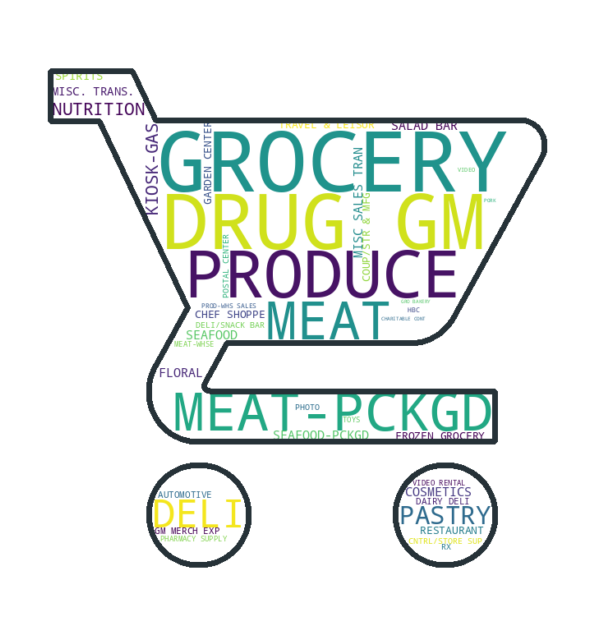

In [327]:
# Preprocess the text to make it all lower case and remove leading/trailing spaces
frequence_produits = np.log(
    df_trnsct.merge(df_product, how="left", on="PRODUCT_ID")[
        "DEPARTMENT"
    ].value_counts()
)

mask = np.invert(np.array(Image.open("../Assets/WordCloudMask.png")))[::, 150:850]
wordcloud = WordCloud(
    background_color="white",
    mask=mask,
    contour_color="#263238",
    contour_width=10,
).generate_from_frequencies(frequence_produits)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## 3. Chiffre d'affaire 

In [328]:
daily_sales.head(3)

,TRANS_DATE,SALES_VALUE
0,2012-01-02,549.31
1,2012-01-03,458.91
2,2012-01-04,1560.37


In [329]:
daily_sales.head(3)

,TRANS_DATE,SALES_VALUE
0,2012-01-02,549.31
1,2012-01-03,458.91
2,2012-01-04,1560.37


## 4. New Customers

In [330]:
customer_first_date

,Day_of_first_purchase
household_key,
1,2012-02-21
2,2012-04-13
3,2012-04-23
4,2012-04-14
5,2012-03-26
...,...
2496,2012-04-27
2497,2012-03-19
2498,2012-04-15


---

# **<span > Préprocessing of paragraph from PDF</span>**


In [331]:
from unidecode import unidecode
import re
from nltk.stem import SnowballStemmer

### **<span >1. Corpus creation and exploration of data</span>**


In [332]:
def count_paragraphs(corpus):
    return len(corpus)

# Example from PDF description of dataset:
corpus = [
    "This dataset contains household level transactions over two years from a group of 2500 households who are frequent shoppers at a retailer. It contains all of each households purchases, not just those from a limited number of categories. For certain households, demographic information as well as direct marketing contact history are included.",
    "Due to the number of tables and the overall complexity of The Complete Journey, it is suggested that this database be used in more advanced classroom settings. Further, The Complete Journey would be ideal for academic research as it should enable one to study the effects of direct marketing to customers.",
    "The following are examples of questions that could be submitted to students or considered for academic research: How many customers are spending more over time? Less over time? Describe these customers. Of those customers who are spending more over time, which categories are growing at a faster rate? Of those customers who are spending less over time, with which categories are they becoming less engaged? Which demographic factors (e.g. household size, presence of children, income) appear to affect customer spend? Engagement with certain categories? Is there evidence to suggest that direct marketing improves overall engagement?"
]


num_paragraphs = count_paragraphs(corpus)
print(f"Corpus contains {num_paragraphs} paragraphs.")

Corpus contains 3 paragraphs.


#### We could analyse also the lengh of text to know the number of words

In [333]:
i = 1

for doc in corpus:
    print(f"Text {i} lenghts : {len(doc)}")
    i+=1

Text 1 lenghts : 342
Text 2 lenghts : 305
Text 3 lenghts : 634


We could format the corpus text to create a separation between words:

In [334]:
i = 1

for doc in corpus:
    word_list = doc.split() # Separates words in a string using a separator 
                             # default is space.
        
    print(f"The paragraph {i} contain {len(word_list)} words")
    print(f"List of word in paragraph {i} : {word_list } \n")
    i+=1

The paragraph 1 contain 52 words
List of word in paragraph 1 : ['This', 'dataset', 'contains', 'household', 'level', 'transactions', 'over', 'two', 'years', 'from', 'a', 'group', 'of', '2500', 'households', 'who', 'are', 'frequent', 'shoppers', 'at', 'a', 'retailer.', 'It', 'contains', 'all', 'of', 'each', 'households', 'purchases,', 'not', 'just', 'those', 'from', 'a', 'limited', 'number', 'of', 'categories.', 'For', 'certain', 'households,', 'demographic', 'information', 'as', 'well', 'as', 'direct', 'marketing', 'contact', 'history', 'are', 'included.'] 

The paragraph 2 contain 51 words
List of word in paragraph 2 : ['Due', 'to', 'the', 'number', 'of', 'tables', 'and', 'the', 'overall', 'complexity', 'of', 'The', 'Complete', 'Journey,', 'it', 'is', 'suggested', 'that', 'this', 'database', 'be', 'used', 'in', 'more', 'advanced', 'classroom', 'settings.', 'Further,', 'The', 'Complete', 'Journey', 'would', 'be', 'ideal', 'for', 'academic', 'research', 'as', 'it', 'should', 'enable', '

We decide also to clean the data in order to normalize the document to exploit data on visualisation or modelisation

In [335]:
word_list= [] # list initialization

for doc in corpus:
    word_list.append(doc.lower()) 
    
word_list

['this dataset contains household level transactions over two years from a group of 2500 households who are frequent shoppers at a retailer. it contains all of each households purchases, not just those from a limited number of categories. for certain households, demographic information as well as direct marketing contact history are included.',
 'due to the number of tables and the overall complexity of the complete journey, it is suggested that this database be used in more advanced classroom settings. further, the complete journey would be ideal for academic research as it should enable one to study the effects of direct marketing to customers.',
 'the following are examples of questions that could be submitted to students or considered for academic research: how many customers are spending more over time? less over time? describe these customers. of those customers who are spending more over time, which categories are growing at a faster rate? of those customers who are spending les

In [336]:
# Check if document is str
i = 1

for doc in word_list:
    if type(doc) == str:
        print(f"Document type {i} is {type(doc)}, Let's continue" )
    else :
        print(f"Document type {i} is {type(doc)}, Convert your data" )
        
    i+=1

Document type 1 is <class 'str'>, Let's continue
Document type 2 is <class 'str'>, Let's continue
Document type 3 is <class 'str'>, Let's continue


#### to use the data we will remove accent:

In [337]:
word_list = [unidecode(doc) for doc in corpus]

word_list

['This dataset contains household level transactions over two years from a group of 2500 households who are frequent shoppers at a retailer. It contains all of each households purchases, not just those from a limited number of categories. For certain households, demographic information as well as direct marketing contact history are included.',
 'Due to the number of tables and the overall complexity of The Complete Journey, it is suggested that this database be used in more advanced classroom settings. Further, The Complete Journey would be ideal for academic research as it should enable one to study the effects of direct marketing to customers.',
 'The following are examples of questions that could be submitted to students or considered for academic research: How many customers are spending more over time? Less over time? Describe these customers. Of those customers who are spending more over time, which categories are growing at a faster rate? Of those customers who are spending les

#### to use the data we will remove stop words:

In [338]:
def remove_stop_words(text):
    # Define stop words set
    stop_words = {
        "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", 
        "are", "aren't", "as", "at", "be", "because", "been", "before", "being", "below", 
        "between", "both", "but", "by", "can't", "cannot", "could", "couldn't", "did", 
        "didn't", "do", "does", "doesn't", "doing", "don't", "down", "during", "each", 
        "few", "for", "from", "further", "had", "hadn't", "has", "hasn't", "have", 
        "haven't", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", 
        "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", 
        "i'm", "i've", "if", "in", "into", "is", "isn't", "it", "it's", "its", "itself", 
        "let's", "me", "more", "most", "mustn't", "my", "myself", "no", "nor", "not", 
        "of", "off", "on", "once", "only", "or", "other", "ought", "our", "ours", 
        "ourselves", "out", "over", "own", "same", "shan't", "she", "she'd", "she'll", 
        "she's", "should", "shouldn't", "so", "some", "such", "than", "that", "that's", 
        "the", "their", "theirs", "them", "themselves", "then", "there", "there's", 
        "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", 
        "through", "to", "too", "under", "until", "up", "very", "was", "wasn't", "we", 
        "we'd", "we'll", "we're", "we've", "were", "weren't", "what", "what's", "when", 
        "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", 
        "why's", "with", "won't", "would", "wouldn't", "you", "you'd", "you'll", "you're", 
        "you've", "your", "yours", "yourself", "yourselves"
    }
    
    # Split text into words, remove stop words, and join back into a string
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    cleaned_text = ' '.join(filtered_words)
    
    return cleaned_text
    

# Example usage:
word_list = [
    'This dataset contains household level transactions over two years from a group of 2500 households who are frequent shoppers at a retailer. It contains all of each households purchases, not just those from a limited number of categories. For certain households, demographic information as well as direct marketing contact history are included.',
    'Due to the number of tables and the overall complexity of The Complete Journey, it is suggested that this database be used in more advanced classroom settings. Further, The Complete Journey would be ideal for academic research as it should enable one to study the effects of direct marketing to customers.',
    'The following are examples of questions that could be submitted to students or considered for academic research: How many customers are spending more over time? Less over time? Describe these customers. Of those customers who are spending more over time, which categories are growing at a faster rate? Of those customers who are spending less over time, with which categories are they becoming less engaged? Which demographic factors (e.g. household size, presence of children, income) appear to affect customer spend? Engagement with certain categories? Is there evidence to suggest that direct marketing improves overall engagement?'
]

cleaned_word_list = [remove_stop_words(text) for text in word_list]
print("Cleaned word list:")
for cleaned_text in cleaned_word_list:
    print(cleaned_text)


Cleaned word list:
dataset contains household level transactions two years group 2500 households frequent shoppers retailer. contains households purchases, just limited number categories. certain households, demographic information well direct marketing contact history included.
Due number tables overall complexity Complete Journey, suggested database used advanced classroom settings. Further, Complete Journey ideal academic research enable one study effects direct marketing customers.
following examples questions submitted students considered academic research: many customers spending time? Less time? Describe customers. customers spending time, categories growing faster rate? customers spending less time, categories becoming less engaged? demographic factors (e.g. household size, presence children, income) appear affect customer spend? Engagement certain categories? evidence suggest direct marketing improves overall engagement?


In [339]:
def clean_text(text):
    # Remove special characters except whitespace and letters
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    return cleaned_text

# Example usage:
word_list = [
    'dataset contains household level transactions two years group 2500 households frequent shoppers retailer. contains households purchases, just limited number categories. certain households, demographic information well direct marketing contact history included.',
    'Due number tables overall complexity Complete Journey, suggested database used advanced classroom settings. Further, Complete Journey ideal academic research enable one study effects direct marketing customers.',
    'following examples questions submitted students considered academic research: many customers spending time? Less time? Describe customers. customers spending time, categories growing faster rate? customers spending less time, categories becoming less engaged? demographic factors (e.g. household size, presence children, income) appear affect customer spend? Engagement certain categories? evidence suggest direct marketing improves overall engagement?'
]

cleaned_word_list = [clean_text(text) for text in word_list]
print("Cleaned word list:")
for cleaned_text in cleaned_word_list:
    print(cleaned_text)

Cleaned word list:
dataset contains household level transactions two years group  households frequent shoppers retailer contains households purchases just limited number categories certain households demographic information well direct marketing contact history included
Due number tables overall complexity Complete Journey suggested database used advanced classroom settings Further Complete Journey ideal academic research enable one study effects direct marketing customers
following examples questions submitted students considered academic research many customers spending time Less time Describe customers customers spending time categories growing faster rate customers spending less time categories becoming less engaged demographic factors eg household size presence children income appear affect customer spend Engagement certain categories evidence suggest direct marketing improves overall engagement


In [340]:
cleaned_word_list

['dataset contains household level transactions two years group  households frequent shoppers retailer contains households purchases just limited number categories certain households demographic information well direct marketing contact history included',
 'Due number tables overall complexity Complete Journey suggested database used advanced classroom settings Further Complete Journey ideal academic research enable one study effects direct marketing customers',
 'following examples questions submitted students considered academic research many customers spending time Less time Describe customers customers spending time categories growing faster rate customers spending less time categories becoming less engaged demographic factors eg household size presence children income appear affect customer spend Engagement certain categories evidence suggest direct marketing improves overall engagement']

In [341]:
stemmer = SnowballStemmer('english') # Vous initialisez le stemmer en anglais

cleaned_word_list = [" ".join([stemmer.stem(word) for word in doc.split()]) for doc in cleaned_word_list]

cleaned_word_list

['dataset contain household level transact two year group household frequent shopper retail contain household purchas just limit number categori certain household demograph inform well direct market contact histori includ',
 'due number tabl overal complex complet journey suggest databas use advanc classroom set further complet journey ideal academ research enabl one studi effect direct market custom',
 'follow exampl question submit student consid academ research mani custom spend time less time describ custom custom spend time categori grow faster rate custom spend less time categori becom less engag demograph factor eg household size presenc children incom appear affect custom spend engag certain categori evid suggest direct market improv overal engag']

##### The document has been stemmed by Python function, this set of words could be use now

---

# Export

### Export the processed datasets to use in the streamlit dashboard

In [342]:
df_demographic.to_csv(export_folder + "hh_demographic_cleaned.csv",index=False)
print("Exported hh_demographic_cleaned.csv")

Exported hh_demographic_cleaned.csv


In [343]:
df_trnsct.to_csv(export_folder + "transaction_data_cleaned.csv",index=False)
print("Exported transaction_data_cleaned.csv")

Exported transaction_data_cleaned.csv


In [344]:
daily_sales.to_csv(export_folder + "daily_sales.csv",index=False)
print("Exported daily_sales.csv")

Exported daily_sales.csv


In [345]:
df_customer_acquisition.to_csv(export_folder + "customer_acquisition.csv",index=False)
print("Exported customer_acquisition.csv")

Exported customer_acquisition.csv


In [346]:
df_product.to_csv(export_folder + "product_cleaned.csv",index=False)
print("Exported product_cleaned.csv")

Exported product_cleaned.csv
